# Zillow Time Series Analysis

## Business Understanding

A client broker is looking advise his clients as to where they should invest in residential real estate.  They want to buy in the US but are agnostic as to where.  

The clients are looking for an understanding of past performance for both long and short term time horizons (3 year ROI and 10 year ROI) as well as gaging volatility in each local market place (represented by the coefficient of variance).  They also want to see forward looking modeling projections.

1. What has shown the best long term appreciation?
2. What has shown the best short term appreciation?
3. What location has the least amount of risk investing?
4. Can future median house prices in a location be predicted and what are the projections?
5. Where do we recomend investing?

### Metric for Success

RMSE or root mean square error is used to show strengh of the model.  It was chosen because it represents the average dollar difference between real and predicted values.

### Time Frame

Although the data goes back to 1996, we are only going to look back 10 years for analysis as trends and price history further back than that becomes dated and is less relevant in predicted future performance.

### Steps

1. Data Prep
2. Data Cleaning
3. EDA
4. Decomposition/ feature engineering
5. Modeling
6. Findings

## Data Preparation

In [112]:
#Importing necessary Packages
import warnings
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
from collections import Counter
import folium
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.pylab import rcParams
%matplotlib inline
import seaborn as sb
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)


In [2]:
#Loading our dataset
df = pd.read_csv('zillow_data.csv')

In [3]:
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,NaN,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


#### Data Cleaning

Lets change RegionName to zipcode

In [4]:
df= df.rename(columns={'RegionName': 'Zipcode'})

In [5]:
#check if data is missing for each column
df.isna().sum()

RegionID       0
Zipcode        0
City           0
State          0
Metro       1043
            ... 
2017-12        0
2018-01        0
2018-02        0
2018-03        0
2018-04        0
Length: 272, dtype: int64

In [6]:
#checking total missing values
df.isna().sum().sum()

157934

In [7]:
#expanding visible columns
pd.set_option('display.max_columns', None)
df

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,426200.0,432600.0,438600.0,444200.0,450000.0,455900.0,462100.0,468500.0,475300.0,482500.0,490200.0,498200.0,507200.0,516800.0,526300.0,535300.0,544500.0,553500.0,562400.0,571200.0,579800.0,588100.0,596300.0,604200.0,612200.0,620200.0,627700.0,634500.0,641000.0,647000.0,652700.0,658100.0,663300.0,668400.0,673400.0,678300.0,683200.0,688300.0,693300.0,698000.0,702400.0,706400.0,710200.0,714000.0,717800.0,721700.0,725700.0,729900.0,733400.0,735600.0,737200.0,739000.0,740900.0,742700.0,744400.0,746000.0,747200.0,748000.0,749000.0,750200.0,752300.0,755300.0,759200.0,764000.0,769600.0,775600.0,781900.0,787900.0,793200.0,798200.0,803100.0,807900.0,812900.0,818100.0,823100.0,828300.0,834100.0,839800.0,845600.0,851800.0,858000.0,864400.0,870700.0,876200.0,880700.0,884400.0,887600.0,890500.0,893300.0,895500.0,897300.0,899000.0,900400.0,902000.0,904400.0,907100.0,909700.0,911900.0,913000.0,913000.0,912000.0,909300.0,905300.0,901400.0,897900.0,895400.0,893600.0,891100.0,887000.0,881700.0,875900.0,870300.0,865100.0,859000.0,851500.0,843800.0,836400.0,830700.0,827300.0,824800.0,821600.0,818300.0,814600.0,809800.0,803600.0,795500.0,786900.0,780700.0,776900.0,774700.0,774200.0,774400.0,774600.0,775600.0,777800.0,775200.0,767900.0,764700.0,766100.0,764100.0,759700.0,754900.0,746200.0,737300.0,730800.0,729300.0,730200.0,730700.0,730000.0,730100.0,730100.0,731200.0,733900.0,735500.0,735400.0,734400.0,737500.0,737700.0,733700.0,734000.0,740300.0,744600.0,750500.0,760400.0,771800.0,780600.0,787

In [8]:
#checking single date column for missing values
df['2014-06'].isna().sum()

56

In [9]:
#replacing missing values with "missing"
df['Metro'].fillna('missing', inplace=True)

In [10]:
#interpolate median house values for each month in which there is an absent value
df.interpolate(inplace=True)
df

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,426200.0,432600.0,438600.0,444200.0,450000.0,455900.0,462100.0,468500.0,475300.0,482500.0,490200.0,498200.0,507200.0,516800.0,526300.0,535300.0,544500.0,553500.0,562400.0,571200.0,579800.0,588100.0,596300.0,604200.0,612200.0,620200.0,627700.0,634500.0,641000.0,647000.0,652700.0,658100.0,663300.0,668400.0,673400.0,678300.0,683200.0,688300.0,693300.0,698000.0,702400.0,706400.0,710200.0,714000.0,717800.0,721700.0,725700.0,729900.0,733400.0,735600.0,737200.0,739000.0,740900.0,742700.0,744400.0,746000.0,747200.0,748000.0,749000.0,750200.0,752300.0,755300.0,759200.0,764000.0,769600.0,775600.0,781900.0,787900.0,793200.0,798200.0,803100.0,807900.0,812900.0,818100.0,823100.0,828300.0,834100.0,839800.0,845600.0,851800.0,858000.0,864400.0,870700.0,876200.0,880700.0,884400.0,887600.0,890500.0,893300.0,895500.0,897300.0,899000.0,900400.0,902000.0,904400.0,907100.0,909700.0,911900.0,913000.0,913000.0,912000.0,909300.0,905300.0,901400.0,897900.0,895400.0,893600.0,891100.0,887000.0,881700.0,875900.0,870300.0,865100.0,859000.0,851500.0,843800.0,836400.0,830700.0,827300.0,824800.0,821600.0,818300.0,814600.0,809800.0,803600.0,795500.0,786900.0,780700.0,776900.0,774700.0,774200.0,774400.0,774600.0,775600.0,777800.0,775200.0,767900.0,764700.0,766100.0,764100.0,759700.0,754900.0,746200.0,737300.0,730800.0,729300.0,730200.0,730700.0,730000.0,730100.0,730100.0,731200.0,733900.0,735500.0,735400.0,734400.0,737500.0,737700.0,733700.0,734000.0,740300.0,744600.0,750500.0,760400.0,771800.0,780600.0,787

In [11]:
#checking for missing values
df.isna().sum().sum()

0

In [12]:
#checking for duplicates
df.duplicated().sum()

0

In [13]:
#checking data types
df.dtypes

RegionID     int64
Zipcode      int64
City        object
State       object
Metro       object
             ...  
2017-12      int64
2018-01      int64
2018-02      int64
2018-03      int64
2018-04      int64
Length: 272, dtype: object

Zipcodes are integers but should be strings as they will be used as categorical data.  Lets convert.

In [14]:
#data type from integer to string
df['Zipcode']= df['Zipcode'].astype('string')

In [15]:
#checking for issues
print(df.Zipcode.min())
print(df.Zipcode.max())

1001
99901


There are some zip codes with 4 digits and after checking a few items it seems like there is a missing 0 at the beginning so for all 4 digit zip codes lets add a 0 in front. 

In [16]:
for i in range(len(df)):
    df.Zipcode[i]= df.Zipcode[i].rjust(5, '0')

In [17]:
print(df.Zipcode.min())

01001


#### Column Creation

##### ROI

I'm going to look at long term and short term real estate investing returns with a 10 year and 3 year ROI for each zip code. 

ROI3 = Median Home Price Return over previous 3 years

ROI10 = Median Home Price Return over previous 10 years

In [31]:
#creating ROI3 and ROI10 columns
df['ROI3'] = (df['2018-04']/ df['2015-04'])-1
df['ROI10']= (df['2018-04']/ df['2008-04'])-1

##### Coefficient of Variation (CV)

Coefficient of Variation is used to show volatility.  It is calculated by mean / standard deviation.  It provides insight into how much risk was taken in each unit of return.  The lower the better.

In [34]:
#calculating std to be used to find CV for 3 and 10 year horizon
df["std3"] = df.loc[:, "2015-04":"2018-04"].std(skipna=True, axis=1)
df["std10"] = df.loc[:, "2008-04":"2018-04"].std(skipna=True, axis=1)

#calculating mean to be used to find CV for 3 and 10 year horizon
df["mean3"] = df.loc[:, "2015-04":"2018-04"].mean(skipna=True, axis=1)
df["mean10"] = df.loc[:, "2008-04":"2018-04"].mean(skipna=True, axis=1)

# calculating and creating new columns - CV for 3 and 10 year
df["CV3"] = df['std3']/df["mean3"]
df["CV10"] = df['std10']/df["mean10"]

# dropping std and mean as they are not necessary for analysis

df.drop(["std3", "mean3"], inplace=True, axis=1)

df.drop(["std10", "mean10"], inplace=True, axis=1)

#### Convert Data to Time Series

In [35]:
dfts= df.copy()

In [36]:
#wideview to long view
def melt_df(data):
    melted = pd.melt(data, id_vars=['RegionID','Zipcode', 'City', 'State', 'Metro', 'CountyName', 'SizeRank', 'ROI3', 'ROI10', 'CV3', 'CV10' 
                                   ], var_name='Date')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [37]:
dfts= melt_df(dfts)

In [38]:
# Converting the date data type into date time and indexing

dfts['Date'] = pd.to_datetime(dfts['Date'], format='%m/%y')

# Set the 'Date' column as index

dfts.set_index('Date', inplace=True)


In [39]:
# renaming the column value to median_price

dfts.rename(columns = {"value" : "Median Price"}, inplace=True)

In [40]:
dfts.tail()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,ROI3,ROI10,CV3,CV10,Median Price
Date,,,,,,,,,,,,
2018-04-01,58333,01338,Ashfield,MA,Greenfield Town,Franklin,14719,0.090104,0.058140,0.058664,0.061037,209300.0
2018-04-01,59107,03293,Woodstock,NH,Claremont,Grafton,14720,0.224512,-0.005724,0.064043,0.070133,225800.0
2018-04-01,75672,40404,Berea,KY,Richmond,Madison,14721,0.270476,0.292636,0.073476,0.069886,133400.0
2018-04-01,93733,81225,Mount Crested Butte,CO,missing,Gunnison,14722,0.202099,0.040238,0.098914,0.098244,664400.0
2018-04-01,95851,89155,Mesquite,NV,Las Vegas,Clark,14723,0.227491,0.048430,0.061221,0.179319,357200.0


In [41]:
#### Column Creation

In [ ]:
##### ROI

In [ ]:
#I'm going to look at long term and short term real estate investing returns with a 10 year and 3 year ROI for each zip code. 

#ROI3 = Median Home Price Return over previous 3 years

#ROI10 = Median Home Price Return over previous 10 years

In [ ]:
#creating ROI3 and ROI10 columns
#dfts['ROI3']= dfts['Median Price'].iloc

In [ ]:
##### Coefficient of Variation (CV)

In [ ]:
#Coefficient of Variation is used to show volatility.  It is calculated by mean / standard deviation.  It provides insight into how much risk was taken in each unit of return.  The lower the better.

In [ ]:
#calculating std to be used to find CV for 3 and 10 year horizon
#df["std3"] = df.loc[:, "2015-04":"2018-04"].std(skipna=True, axis=1)
#df["std10"] = df.loc[:, "2008-04":"2018-04"].std(skipna=True, axis=1)

#calculating mean to be used to find CV for 3 and 10 year horizon
#df["mean3"] = df.loc[:, "2015-04":"2018-04"].mean(skipna=True, axis=1)
#df["mean10"] = df.loc[:, "2008-04":"2018-04"].mean(skipna=True, axis=1)

# calculating and creating new columns - CV for 3 and 10 year
#df["CV3"] = df['std3']/df["mean3"]
#df["CV10"] = df['std10']/df["mean10"]

# dropping std and mean as they are not necessary for analysis

#df.drop(["std3", "mean3"], inplace=True, axis=1)

#df.drop(["std10", "mean10"], inplace=True, axis=1)

As we are only looking at pricing data over the last 10 years, we can drop all dates prior to 04/2008.

In [42]:
#stats on our data
dfts.describe()

,RegionID,SizeRank,ROI3,ROI10,CV3,CV10,Median Price
count,3.901595e+06,3.901595e+06,3.901595e+06,3.901595e+06,3.901595e+06,3.901595e+06,3.901595e+06
mean,8.107501e+04,7.362000e+03,2.084634e-01,1.325294e-01,6.093964e-02,1.219175e-01,2.060636e+05
std,3.193304e+04,4.250165e+03,1.355057e-01,2.760309e-01,3.089400e-02,9.645167e-02,2.368017e+05
min,5.819600e+04,1.000000e+00,-3.701685e-01,-9.165343e-01,5.335258e-03,6.983217e-03,1.130000e+04
25%,6.717400e+04,3.681000e+03,1.172414e-01,-6.435006e-03,3.868667e-02,6.599638e-02,9.770000e+04
50%,7.800700e+04,7.362000e+03,1.883068e-01,1.207087e-01,5.595020e-02,9.700731e-02,1.469000e+05
75%,9.092100e+04,1.104300e+04,2.771536e-01,2.509747e-01,7.708539e-02,1.503795e-01,2.354000e+05
max,7.538440e+05,1.472300e+04,1.455631e+00,7.187392e+00,2.932837e-01,1.355201e+00,1.931490e+07


In [43]:
#drop rows before our analysis range
dfts.drop(pd.date_range('1996-04-01', '2008-03-01'), errors='ignore', inplace=True)

In [44]:
#stats on our data
dfts.describe()

,RegionID,SizeRank,ROI3,ROI10,CV3,CV10,Median Price
count,1.781483e+06,1.781483e+06,1.781483e+06,1.781483e+06,1.781483e+06,1.781483e+06,1.781483e+06
mean,8.107501e+04,7.362000e+03,2.084634e-01,1.325294e-01,6.093964e-02,1.219175e-01,2.311444e+05
std,3.193304e+04,4.250165e+03,1.355057e-01,2.760309e-01,3.089401e-02,9.645169e-02,2.838479e+05
min,5.819600e+04,1.000000e+00,-3.701685e-01,-9.165343e-01,5.335258e-03,6.983217e-03,1.330000e+04
25%,6.717400e+04,3.681000e+03,1.172414e-01,-6.435006e-03,3.868667e-02,6.599638e-02,1.112000e+05
50%,7.800700e+04,7.362000e+03,1.883068e-01,1.207087e-01,5.595020e-02,9.700731e-02,1.635000e+05
75%,9.092100e+04,1.104300e+04,2.771536e-01,2.509747e-01,7.708539e-02,1.503795e-01,2.611000e+05
max,7.538440e+05,1.472300e+04,1.455631e+00,7.187392e+00,2.932837e-01,1.355201e+00,1.931490e+07


The mean and median "median price" increased after we dropped the older pricing data.  This means unsurprisingly home prices have increased over time.

## EDA

Looking to see which countys have the most top 50 entries entries for ROI and CV.

In [60]:
#creating a copy of dfts
present= dfts.copy()


In [61]:
#dropping all rows before current month to analyze ROI
present.drop(pd.date_range('2008-04-01', '2018-03-01'), errors='ignore', inplace=True)
present

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,ROI3,ROI10,CV3,CV10,Median Price
Date,,,,,,,,,,,,
2018-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,0.133275,0.191307,0.036680,0.111514,1030600.0
2018-04-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,0.247287,0.523674,0.062112,0.175985,321800.0
2018-04-01,91982,77494,Katy,TX,Houston,Harris,3,0.077400,0.322244,0.017360,0.117473,329900.0
2018-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,0.102302,0.142383,0.029749,0.117081,1307000.0
2018-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,0.054688,-0.053001,0.020136,0.030683,121500.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,58333,01338,Ashfield,MA,Greenfield Town,Franklin,14719,0.090104,0.058140,0.058664,0.061037,209300.0
2018-04-01,59107,03293,Woodstock,NH,Claremont,Grafton,14720,0.224512,-0.005724,0.064043,0.070133,225800.0
2018-04-01,75672,40404,Berea,KY,Richmond,Madison,14721,0.270476,0.292636,0.073476,0.069886,133400.0


In [63]:
#best places to invest by county in last 3 years by number of zip codes in top 50
dfr3= present.sort_values(by='ROI3', ascending= False).head(50)
dfr3['CountyName'].value_counts()

Volusia         3
Hudson          3
Duval           3
Polk            3
Brevard         3
Miami-Dade      2
Dallas          2
Pinellas        2
Pasco           2
Davidson        2
Dekalb          2
Charleston      2
Saint Lucie     2
Franklin        1
Wake            1
Manatee         1
Hillsborough    1
Allegheny       1
Kent            1
Clark           1
Broward         1
Durham          1
Saint Johns     1
Mecklenburg     1
Marion          1
Wyandotte       1
Philadelphia    1
Greenville      1
Hamilton        1
Palm Beach      1
Charlotte       1
Perquimans      1
Name: CountyName, dtype: int64

4/5 of the countys with the most entries in the top ROI in the past three years are in Florida.  No county has more than three entries.

In [64]:
#average 3 year ROI vs Florida 3 year ROI
FLdf= present[present['State']== 'FL']
print("FL 3 year ROI:",(FLdf['ROI3'].mean()))
print('National 3 year ROI',(df['ROI3'].mean()))

FL 3 year ROI: 0.3622110325456214
National 3 year ROI 0.2084633953135752


In [66]:
#best places to invest by county over last 10 years by number of zip codes in top 50
dfr10= present.sort_values(by='ROI10', ascending= False).head(50)
dfr10['CountyName'].value_counts()

Santa Clara     10
Kauai            3
Kings            3
Camden           2
Allegheny        2
Los Angeles      2
Middlesex        2
Contra Costa     2
Clinton          1
Denver           1
Williams         1
San Juan         1
Napa             1
Pinellas         1
Alameda          1
Kent             1
Saint Louis      1
Queens           1
Bottineau        1
Davidson         1
Campbell         1
Citrus           1
Mariposa         1
Glynn            1
Madera           1
Suffolk          1
Arapahoe         1
Grafton          1
Leelanau         1
Carbon           1
Madison          1
San Mateo        1
Name: CountyName, dtype: int64

Santa Clara is all alone at the top with 10 entries in the top 50 highest 10 year ROI zipcodes.

In [67]:
#average 10 year ROI vs SantaClara 10 year ROI
SCdf= present[present['CountyName']== 'Santa Clara']
print(SCdf['ROI10'].mean())
print(df['ROI10'].mean())

0.8808352097194927
0.13252944384653423


Over the last 10 years Santa Clara County homes have an average return of 88% compared to 13% national average.

In [68]:
#lowest price volatility last 3 years
dfc3= present.sort_values(by='CV3', ascending= True).head(50)
dfc3['CountyName'].value_counts()

Jasper              6
Cook                3
McLean              3
Anchorage           3
Somerset            2
Harris              2
Fairfield           2
Montgomery          2
Howard              2
Fort Bend           1
Huntingdon          1
Sumter              1
Champaign           1
Natrona             1
McKinley            1
Putnam              1
Madison             1
Rock Island         1
Orange              1
Clay                1
Tom Green           1
East Baton Rouge    1
Bell                1
Bowie               1
Raleigh             1
Middlesex           1
Knox                1
Nelson              1
Carroll             1
McKean              1
Washington          1
Walsh               1
Burleigh            1
Bremer              1
Name: CountyName, dtype: int64

In [69]:
#lowest price volatility over last 10 years
dfc10= present.sort_values(by='CV10', ascending= True).head(50)
dfc10['CountyName'].value_counts()

El Paso                 5
Fairbanks North Star    4
Jasper                  4
Matanuska Susitna       3
Peoria                  3
Erie                    2
McLean                  2
Clinton                 2
Christian               2
Grant                   2
Pulaski                 2
Pottawattamie           1
Moore                   1
Rock Island             1
Bowie                   1
Anderson                1
Sumter                  1
Crawford                1
Otsego                  1
Harnett                 1
Warren                  1
Somerset                1
Hoke                    1
Cabell                  1
Stephens                1
Franklin                1
Refugio                 1
Lee                     1
Bell                    1
Tazewell                1
Name: CountyName, dtype: int64

In [70]:
#lowest ROI last 3 years
df3r= present.sort_values(by='ROI3', ascending= True).head(50)
df3r['CountyName'].value_counts()

Darke           6
Brown           3
Dougherty       3
Marion          2
Saint James     2
Rockingham      2
Osborne         2
Kankakee        2
New York        2
Manitowoc       2
Mercer          1
Whiteside       1
Caddo           1
Jersey          1
Luzerne         1
Cook            1
Lafayette       1
Somerset        1
Greene          1
Perquimans      1
Atlantic        1
Newton          1
Harrison        1
Jasper          1
Pittsylvania    1
McDonough       1
Stafford        1
Hinds           1
Smith           1
Nash            1
La Salle        1
Edwards         1
Cambria         1
Tishomingo      1
Name: CountyName, dtype: int64

Darke county in Ohio has he most zip codes in the bottom 50 performing ROI.

In [71]:
#lowest ROI last 10 years
df10r= present.sort_values(by='ROI10', ascending= True).head(50)
df10r['CountyName'].value_counts()

Pike          2
Schuylkill    2
Jefferson     2
Lee           2
Haskell       2
McDonough     2
Washington    2
Montgomery    2
Barton        1
Van Buren     1
Johnson       1
Baylor        1
Licking       1
Labette       1
Franklin      1
Pawnee        1
Madison       1
Otter Tail    1
Scott         1
Quitman       1
Saint Mary    1
Brown         1
Calhoun       1
Fayette       1
Jewell        1
Pushmataha    1
Wexford       1
Decatur       1
Neosho        1
Walthall      1
Sullivan      1
Cambria       1
Osborne       1
Edwards       1
Guadalupe     1
Keokuk        1
Muskegon      1
Stafford      1
Morgan        1
Phelps        1
Lamb          1
Pondera       1
Name: CountyName, dtype: int64

In [72]:
#Looking at most expensive zip code
present.sort_values('Median Price', ascending=False)

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,ROI3,ROI10,CV3,CV10,Median Price
Date,,,,,,,,,,,,
2018-04-01,61635,10021,New York,NY,New York,New York,273,0.075156,0.723049,0.034355,0.219415,17894900.0
2018-04-01,61625,10011,New York,NY,New York,New York,21,0.085675,0.996261,0.038171,0.254585,11478300.0
2018-04-01,61628,10014,New York,NY,New York,New York,509,-0.098535,0.543988,0.034983,0.192757,8959300.0
2018-04-01,61703,10128,New York,NY,New York,New York,22,-0.104003,0.295395,0.062761,0.138422,7386600.0
2018-04-01,97518,94027,Atherton,CA,San Francisco,San Mateo,10238,0.322199,0.989608,0.079054,0.285141,6796500.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,76354,42410,Earlington,KY,Madisonville,Hopkins,14386,0.038136,-0.054054,0.019764,0.052280,24500.0
2018-04-01,79244,48503,Flint,MI,Flint,Genesee,4382,0.572414,-0.493333,0.113998,0.311824,22800.0
2018-04-01,86105,63556,Milan,MO,missing,Sullivan,11918,0.298246,-0.866346,0.098899,1.208485,22200.0


New York City has the most expensive zipcode by median price while Earle, Arkansas has the least.

In [73]:
#looking at the highest and lowest 3 year ROI
present.sort_values('ROI3', ascending=False)

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,ROI3,ROI10,CV3,CV10,Median Price
Date,,,,,,,,,,,,
2018-04-01,69649,27980,Hertford,NC,Elizabeth City,Perquimans,13410,1.455631,-0.210642,0.293284,0.347789,143900.0
2018-04-01,70817,30032,Candler-Mcafee,GA,Atlanta,Dekalb,843,1.043609,-0.576767,0.198467,0.537075,135900.0
2018-04-01,65801,19134,Philadelphia,PA,Philadelphia,Philadelphia,467,1.017316,-0.186736,0.193643,0.268137,46600.0
2018-04-01,69771,28208,Charlotte,NC,Charlotte,Mecklenburg,1822,0.951807,0.374545,0.208006,0.221464,113400.0
2018-04-01,72768,33705,Saint Petersburg,FL,Tampa,Pinellas,2662,0.941950,0.244211,0.204315,0.313114,177300.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,77592,45331,Greenville,OH,Greenville,Darke,4295,-0.276439,0.017412,0.118250,0.304025,108100.0
2018-04-01,81145,53015,Cleveland,WI,Manitowoc,Manitowoc,13079,-0.284959,0.064885,0.113489,0.228492,148800.0
2018-04-01,77607,45346,New Madison,OH,Greenville,Darke,13486,-0.302147,-0.669151,0.131655,0.383788,91000.0


Hertford NC has the best 3 year ROI while Reddsville Wisc has the worst.

In [74]:
#creating dfs for highest 3 year ROI zip codes and lowest 3 year CV zip codes
ROI3_zipcodes = pd.DataFrame(present.groupby("Zipcode")["ROI3"].mean().sort_values(ascending=False).head(5))
CV3_zipcodes = pd.DataFrame(present.groupby("Zipcode")["CV3"].mean().sort_values(ascending=True).head(5))

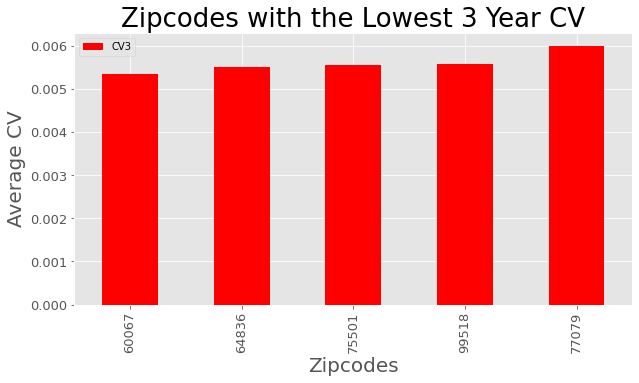

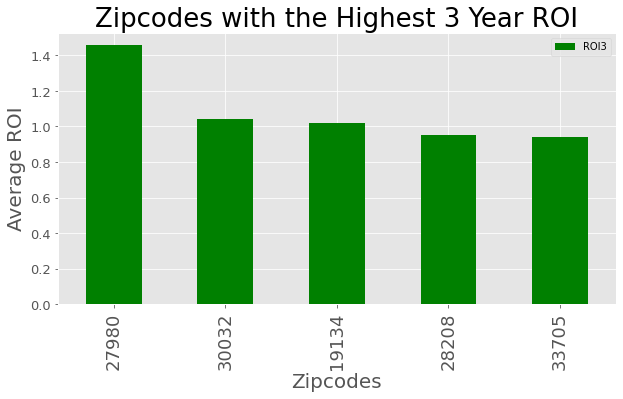

In [158]:
ax1 = CV3_zipcodes.plot(kind='bar', figsize=(10,5), color="red", fontsize=13);
ax1.set_alpha(0.8)

ax2 =ROI3_zipcodes.plot(kind='bar', figsize=(10,5), color="green", fontsize=13);
ax2.set_alpha(0.8)

ax1.set_title("Zipcodes with the Lowest 3 Year CV", fontsize=26)
ax1.set_ylabel("Average CV", fontsize=20);
ax1.set_xlabel("Zipcodes", fontsize=20)


ax2.set_title("Zipcodes with the Highest 3 Year ROI", fontsize=26)
ax2.set_ylabel("Average ROI", fontsize=20);
ax2.set_xlabel("Zipcodes", fontsize=20)
plt.xticks(fontsize= 18)
plt.savefig("output.jpg")
plt.show()

In [76]:
#creating dfs for lowest 3 year ROI and highest 3 year CV
bad_ROI3_zipcodes = pd.DataFrame(present.groupby("Zipcode")["ROI3"].mean().sort_values(ascending=True).head(5))
bad_CV3_zipcodes = pd.DataFrame(present.groupby("Zipcode")["CV3"].mean().sort_values(ascending=False).head(5))

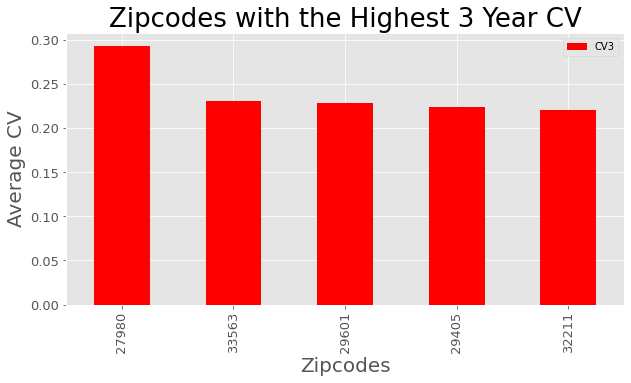

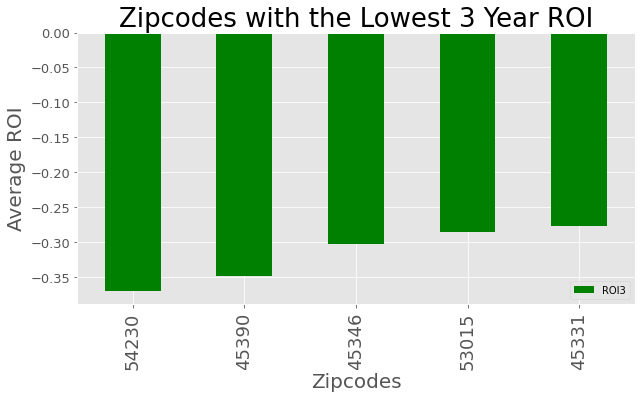

In [77]:
ax1 = bad_CV3_zipcodes.plot(kind='bar', figsize=(10,5), color="red", fontsize=13);
ax1.set_alpha(0.8)

ax2 = bad_ROI3_zipcodes.plot(kind='bar', figsize=(10,5), color="green", fontsize=13);
ax2.set_alpha(0.8)

ax1.set_title("Zipcodes with the Highest 3 Year CV", fontsize=26)
ax1.set_ylabel("Average CV", fontsize=20);
ax1.set_xlabel("Zipcodes", fontsize=20)


ax2.set_title("Zipcodes with the Lowest 3 Year ROI", fontsize=26)
ax2.set_ylabel("Average ROI", fontsize=20);
ax2.set_xlabel("Zipcodes", fontsize=20)
plt.xticks(fontsize= 18)
plt.savefig("output.jpg")
plt.show()

In [78]:
ROI10_zipcodes = pd.DataFrame(present.groupby("Zipcode")["ROI10"].mean().sort_values(ascending=False).head(5))
CV10_zipcodes = pd.DataFrame(present.groupby("Zipcode")["CV10"].mean().sort_values(ascending=True).head(5))

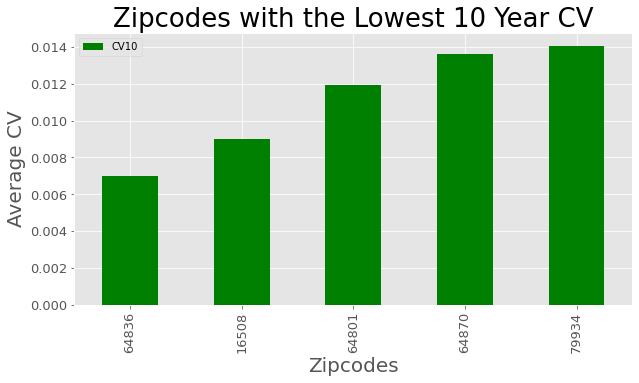

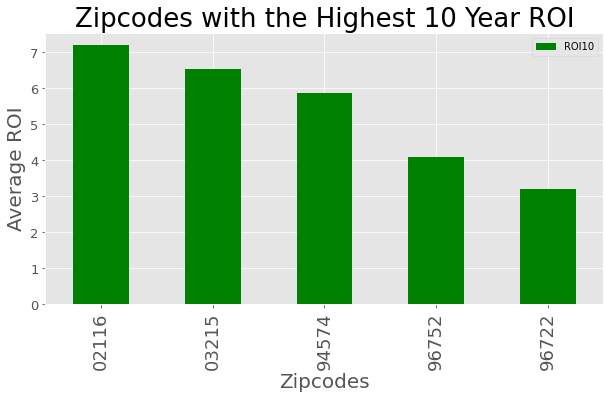

In [159]:
ax1 = CV10_zipcodes.plot(kind='bar', figsize=(10,5), color="green", fontsize=13);
ax1.set_alpha(0.8)

ax2 =ROI10_zipcodes.plot(kind='bar', figsize=(10,5), color="green", fontsize=13);
ax2.set_alpha(0.8)

ax1.set_title("Zipcodes with the Lowest 10 Year CV", fontsize=26)
ax1.set_ylabel("Average CV", fontsize=20);
ax1.set_xlabel("Zipcodes", fontsize=20)


ax2.set_title("Zipcodes with the Highest 10 Year ROI", fontsize=26)
ax2.set_ylabel("Average ROI", fontsize=20);
ax2.set_xlabel("Zipcodes", fontsize=20)
plt.xticks(fontsize= 18)
plt.savefig("output1.jpg")
plt.show()

In [80]:
bad_ROI10_zipcodes = pd.DataFrame(present.groupby("Zipcode")["ROI10"].mean().sort_values(ascending=True).head(5))
bad_CV10_zipcodes = pd.DataFrame(present.groupby("Zipcode")["CV10"].mean().sort_values(ascending=False).head(5))

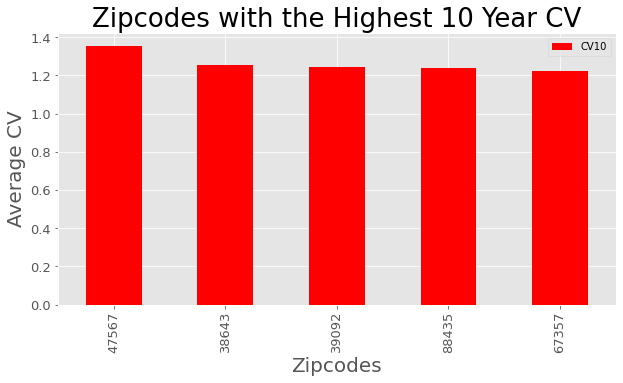

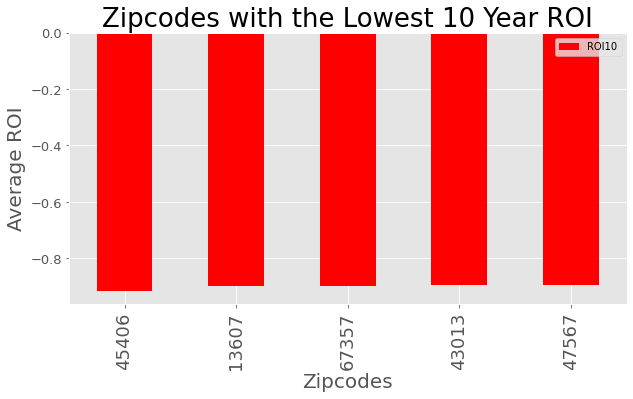

In [81]:
ax1 = bad_CV10_zipcodes.plot(kind='bar', figsize=(10,5), color="red", fontsize=13);
ax1.set_alpha(0.8)

ax2 = bad_ROI10_zipcodes.plot(kind='bar', figsize=(10,5), color="red", fontsize=13);
ax2.set_alpha(0.8)

ax1.set_title("Zipcodes with the Highest 10 Year CV", fontsize=26)
ax1.set_ylabel("Average CV", fontsize=20);
ax1.set_xlabel("Zipcodes", fontsize=20)


ax2.set_title("Zipcodes with the Lowest 10 Year ROI", fontsize=26)
ax2.set_ylabel("Average ROI", fontsize=20);
ax2.set_xlabel("Zipcodes", fontsize=20)
plt.xticks(fontsize= 18)
plt.savefig("output.jpg")
plt.show()

In [82]:
#mean price by month
d1= dfts.groupby(dfts.index.date)['Median Price'].mean()

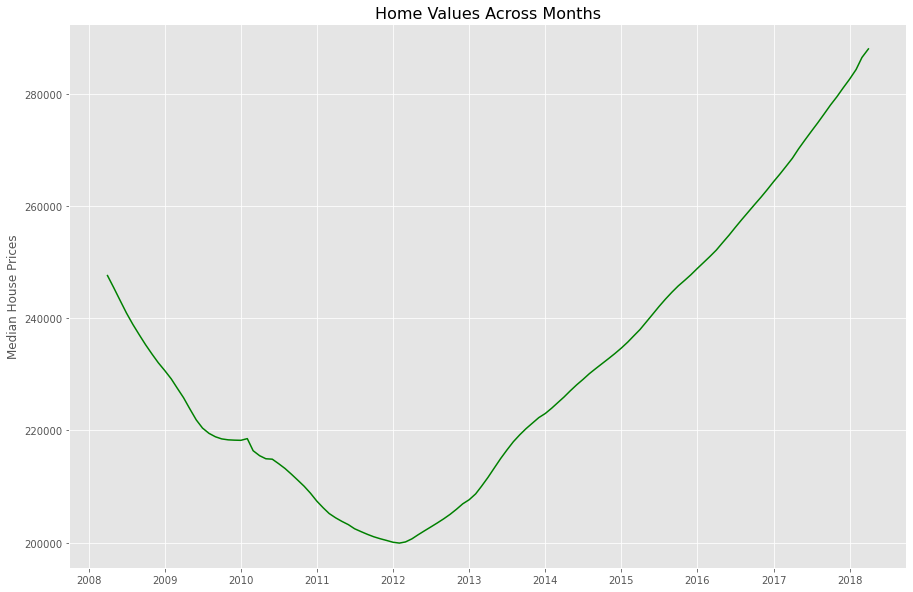

In [83]:
#plot mean price home by month
d1.plot(figsize=(15,10), color="green")
plt.title('Home Values Across Months', fontsize=(16))
plt.ylabel('Median House Prices')
plt.show()

We see the average price of a home dip from 2008 to 2012 where it bottoms and then proceeds to show a strong upward trend.  

In [84]:
# checking for trend, seasonality and residuals in data
from statsmodels.tsa.seasonal import seasonal_decompose

In [114]:
#creating df for lowest 10 year cv
zip10= dfts[dfts['Zipcode']== '64836']
zip10

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,ROI3,ROI10,CV3,CV10,Median Price
Date,,,,,,,,,,,,
2008-04-01,86615,64836,Carthage,MO,Joplin,Jasper,4741,0.00997,0.0,0.005497,0.006983,101300.0
2008-05-01,86615,64836,Carthage,MO,Joplin,Jasper,4741,0.00997,0.0,0.005497,0.006983,101400.0
2008-06-01,86615,64836,Carthage,MO,Joplin,Jasper,4741,0.00997,0.0,0.005497,0.006983,101400.0
2008-07-01,86615,64836,Carthage,MO,Joplin,Jasper,4741,0.00997,0.0,0.005497,0.006983,101300.0
2008-08-01,86615,64836,Carthage,MO,Joplin,Jasper,4741,0.00997,0.0,0.005497,0.006983,101200.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-01,86615,64836,Carthage,MO,Joplin,Jasper,4741,0.00997,0.0,0.005497,0.006983,99000.0
2018-01-01,86615,64836,Carthage,MO,Joplin,Jasper,4741,0.00997,0.0,0.005497,0.006983,98900.0
2018-02-01,86615,64836,Carthage,MO,Joplin,Jasper,4741,0.00997,0.0,0.005497,0.006983,99500.0


In [115]:
zip10= zip10['Median Price']
zip10

Date
2008-04-01    101300.0
2008-05-01    101400.0
2008-06-01    101400.0
2008-07-01    101300.0
2008-08-01    101200.0
                ...   
2017-12-01     99000.0
2018-01-01     98900.0
2018-02-01     99500.0
2018-03-01    100600.0
2018-04-01    101300.0
Name: Median Price, Length: 121, dtype: float64

In [116]:
#creating a definition for trend, seasonality, and residual decomposition
def seasonal_decomposition(df):
    decomposition = seasonal_decompose(df)
    
    # Gather the trend, seasonality, and residuals 
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

# Plot gathered statistics
    plt.figure(figsize=(8,8))
    plt.subplot(411)
    plt.plot(df, label='Original', color='blue')
    #plt.plot(ts, label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout()

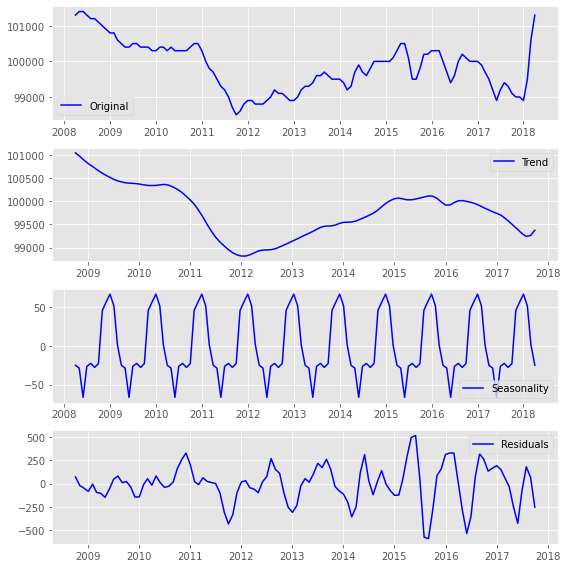

In [117]:
#decompoising zip10
seasonal_decomposition(zip10)

#### Stationarity

In [118]:
#dickey fuller test to confirm the data is not stationary
def check_stationarity(df):
    result = adfuller(df)
  
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [119]:
check_stationarity(zip10)

ADF Statistic: -2.340426
p-value: 0.159261
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580


The p_value is way above .05 and the test statistic is also greater than the critical values therefore we can confirm is not stationary.

#### Detrending via Differencing

In [124]:
#detrending function
def detrend(df):
    '''function returns a stationary series'''
    
    diff_series = df.diff(1).diff(12).dropna()
    return diff_series

In [125]:
#naming detrend
detrended_series = detrend(zip10)

#check the stationarity of the detrended column
check_stationarity(detrended_series)

ADF Statistic: -3.217331
p-value: 0.019003
Critical Values:
	1%: -3.502
	5%: -2.893
	10%: -2.583


The p value is < .05 and the test statistic is < than all critical values.  The series is stationary.

In [ ]:
seasonal_decomposition(detrended_series)

#### Autocorrelation and Partial Correlation

White noise model has a fixed and constant mean and variance with no correlation over time.

A random walk model has no specified mean or variance and has a strong dependence over time.

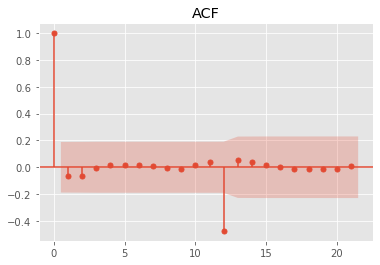

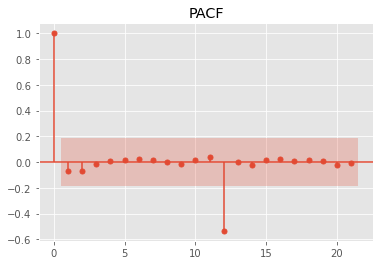

In [94]:
# plotting autocorrelation and partial correlation
acf_plot = plot_acf(detrended_series.dropna(), title="ACF")
pacf_plot = plot_pacf(detrended_series.dropna(), title="PACF")

There is a correlation spike with ACF and PACF indicating this is not White Noise.  There does seem to be some seasonality so we will model with SARIMAX.

### SARIMAX Model

In [126]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [127]:
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(zip10,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue

C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-package

ARIMA (0, 0, 0) x (0, 0, 0, 12): AIC Calculated=3105.262686208715
ARIMA (0, 0, 0) x (0, 0, 1, 12): AIC Calculated=126752.69320308416
ARIMA (0, 0, 0) x (0, 1, 0, 12): AIC Calculated=1723.238037865409
ARIMA (0, 0, 0) x (0, 1, 1, 12): AIC Calculated=1532.7350774329743
ARIMA (0, 0, 0) x (1, 0, 0, 12): AIC Calculated=1733.7962633616062
ARIMA (0, 0, 0) x (1, 0, 1, 12): AIC Calculated=1715.903692618593
ARIMA (0, 0, 0) x (1, 1, 0, 12): AIC Calculated=1549.8104483126335


C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-package

ARIMA (0, 0, 0) x (1, 1, 1, 12): AIC Calculated=1545.6930685065086
ARIMA (0, 0, 1) x (0, 0, 0, 12): AIC Calculated=2995.5257599578363


C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (0, 0, 1, 12): AIC Calculated=115585.57546845943
ARIMA (0, 0, 1) x (0, 1, 0, 12): AIC Calculated=1650.9786283550154


C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (0, 1, 1, 12): AIC Calculated=1410.857308379302
ARIMA (0, 0, 1) x (1, 0, 0, 12): AIC Calculated=2715.7143562853967
ARIMA (0, 0, 1) x (1, 0, 1, 12): AIC Calculated=2667.994399061976


C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-package

ARIMA (0, 0, 1) x (1, 1, 0, 12): AIC Calculated=1441.1683635689062


C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 0, 1) x (1, 1, 1, 12): AIC Calculated=1412.8572895128857
ARIMA (0, 1, 0) x (0, 0, 0, 12): AIC Calculated=1612.819045304561
ARIMA (0, 1, 0) x (0, 0, 1, 12): AIC Calculated=1450.9783072373227
ARIMA (0, 1, 0) x (0, 1, 0, 12): AIC Calculated=1516.6182832347638


C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-package

ARIMA (0, 1, 0) x (0, 1, 1, 12): AIC Calculated=1340.4789761177378
ARIMA (0, 1, 0) x (1, 0, 0, 12): AIC Calculated=1472.8089209023021
ARIMA (0, 1, 0) x (1, 0, 1, 12): AIC Calculated=1451.5545790455699
ARIMA (0, 1, 0) x (1, 1, 0, 12): AIC Calculated=1360.7812787951066


C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-package

ARIMA (0, 1, 0) x (1, 1, 1, 12): AIC Calculated=1349.4031362705755
ARIMA (0, 1, 1) x (0, 0, 0, 12): AIC Calculated=1545.8415382681987
ARIMA (0, 1, 1) x (0, 0, 1, 12): AIC Calculated=1396.9178437530165
ARIMA (0, 1, 1) x (0, 1, 0, 12): AIC Calculated=1468.1803131307702

C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-package


ARIMA (0, 1, 1) x (0, 1, 1, 12): AIC Calculated=1279.464675671312


C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (0, 1, 1) x (1, 0, 0, 12): AIC Calculated=1423.5343652759502
ARIMA (0, 1, 1) x (1, 0, 1, 12): AIC Calculated=1398.4738439732273
ARIMA (0, 1, 1) x (1, 1, 0, 12): AIC Calculated=1330.2919320799151


C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-package

ARIMA (0, 1, 1) x (1, 1, 1, 12): AIC Calculated=1305.5567801169595
ARIMA (1, 0, 0) x (0, 0, 0, 12): AIC Calculated=1627.5785050932718


C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 0) x (0, 0, 1, 12): AIC Calculated=1466.0250252903518
ARIMA (1, 0, 0) x (0, 1, 0, 12): AIC Calculated=1529.8622732611523
ARIMA (1, 0, 0) x (0, 1, 1, 12): AIC Calculated=1361.2883560645746


C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-package

ARIMA (1, 0, 0) x (1, 0, 0, 12): AIC Calculated=1475.024440910252
ARIMA (1, 0, 0) x (1, 0, 1, 12): AIC Calculated=1468.4712831831803


C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 0) x (1, 1, 0, 12): AIC Calculated=1360.9972489581
ARIMA (1, 0, 0) x (1, 1, 1, 12): AIC Calculated=1362.801417844464
ARIMA (1, 0, 1) x (0, 0, 0, 12): AIC Calculated=1561.241173592732


C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-package

ARIMA (1, 0, 1) x (0, 0, 1, 12): AIC Calculated=1520.4729837913815
ARIMA (1, 0, 1) x (0, 1, 0, 12): AIC Calculated=1504.2869456893072


C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 1) x (0, 1, 1, 12): AIC Calculated=1300.127522101262
ARIMA (1, 0, 1) x (1, 0, 0, 12): AIC Calculated=1521.3451747710005


C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 1) x (1, 0, 1, 12): AIC Calculated=1471.845512279236
ARIMA (1, 0, 1) x (1, 1, 0, 12): AIC Calculated=1326.9822397085281


C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 0, 1) x (1, 1, 1, 12): AIC Calculated=1300.760526897981
ARIMA (1, 1, 0) x (0, 0, 0, 12): AIC Calculated=1566.6000416830466
ARIMA (1, 1, 0) x (0, 0, 1, 12): AIC Calculated=1417.1340928266004
ARIMA (1, 1, 0) x (0, 1, 0, 12): AIC Calculated=1477.4635757262383


C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-package

ARIMA (1, 1, 0) x (0, 1, 1, 12): AIC Calculated=1308.8049911643466
ARIMA (1, 1, 0) x (1, 0, 0, 12): AIC Calculated=1419.4304462117154
ARIMA (1, 1, 0) x (1, 0, 1, 12): AIC Calculated=1418.5181674866944


C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-package

ARIMA (1, 1, 0) x (1, 1, 0, 12): AIC Calculated=1309.7230232541929


C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 0) x (1, 1, 1, 12): AIC Calculated=1309.7758674504091
ARIMA (1, 1, 1) x (0, 0, 0, 12): AIC Calculated=1540.026394414405
ARIMA (1, 1, 1) x (0, 0, 1, 12): AIC Calculated=1392.107223534915

C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'



ARIMA (1, 1, 1) x (0, 1, 0, 12): AIC Calculated=1457.7754434643518


C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (0, 1, 1, 12): AIC Calculated=1269.357543791922
ARIMA (1, 1, 1) x (1, 0, 0, 12): AIC Calculated=1405.3922142677256


C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (1, 0, 1, 12): AIC Calculated=1394.099014320609
ARIMA (1, 1, 1) x (1, 1, 0, 12): AIC Calculated=1310.884782885021


C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


ARIMA (1, 1, 1) x (1, 1, 1, 12): AIC Calculated=1264.2722416186634


In [128]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           1264.27
Name: 63, dtype: object

In [131]:
# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(zip10, 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary())

C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                     SARIMAX Results                                      
Dep. Variable:                       Median Price   No. Observations:                  121
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -627.136
Date:                            Sat, 07 Jan 2023   AIC                           1264.272
Time:                                    16:17:30   BIC                           1276.989
Sample:                                04-01-2008   HQIC                          1269.409
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4279      0.126      3.383      0.001       0.180       0.676
ma.L1          0.4318      0.107   

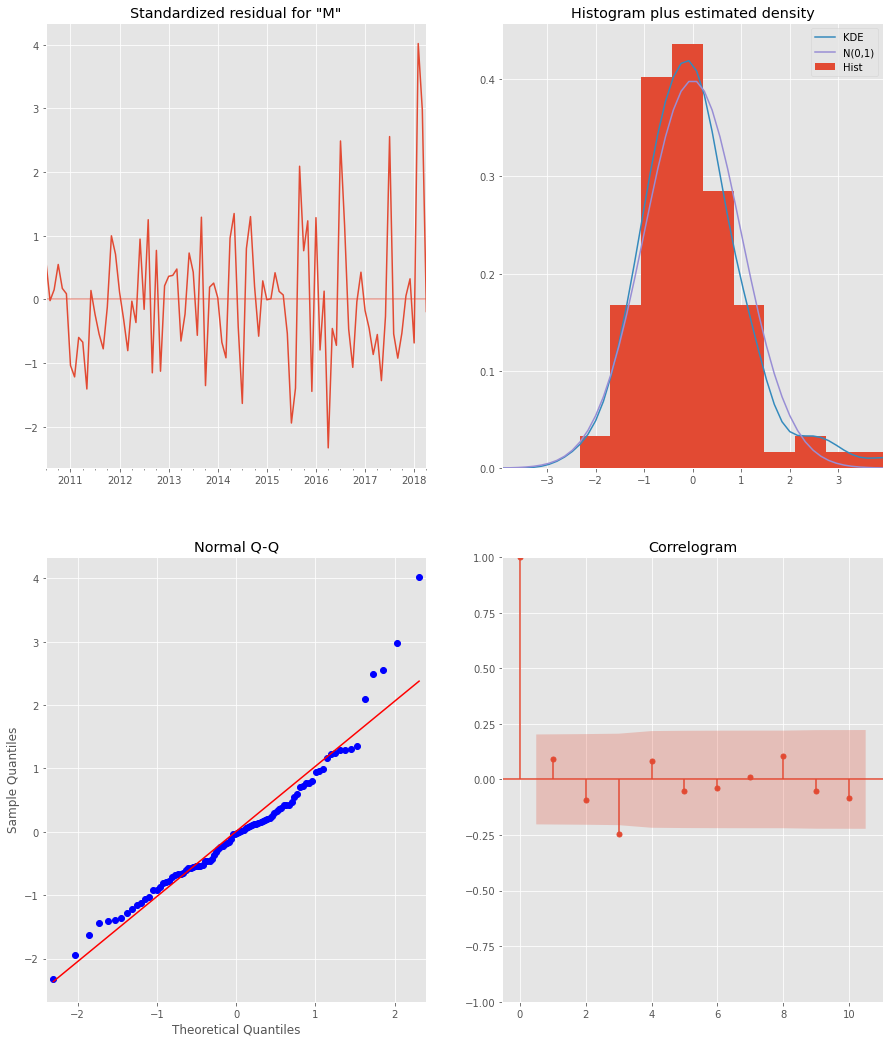

In [132]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

The residuals appear uncorrelated and somewhat normally. AIC is 1264 which measures goodness of fit.  The lower the better.  Lets see if we can improve the model.

In [135]:
#second sarimax model adjusting parameters
ARIMA_model2 = sm.tsa.statespace.SARIMAX(zip10,
                                order=(3, 1, 3),
                                seasonal_order=(3, 1, 3, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output2 = my_model2.fit()

print(results2.summary())

C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\jakes\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                       Median Price   No. Observations:                  121
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 12)   Log Likelihood                -454.584
Date:                            Sat, 07 Jan 2023   AIC                            935.168
Time:                                    16:24:36   BIC                            964.022
Sample:                                04-01-2008   HQIC                           946.601
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2729      0.596      0.458      0.647      -0.895       1.441
ar.L2         -0.2243      0.393   

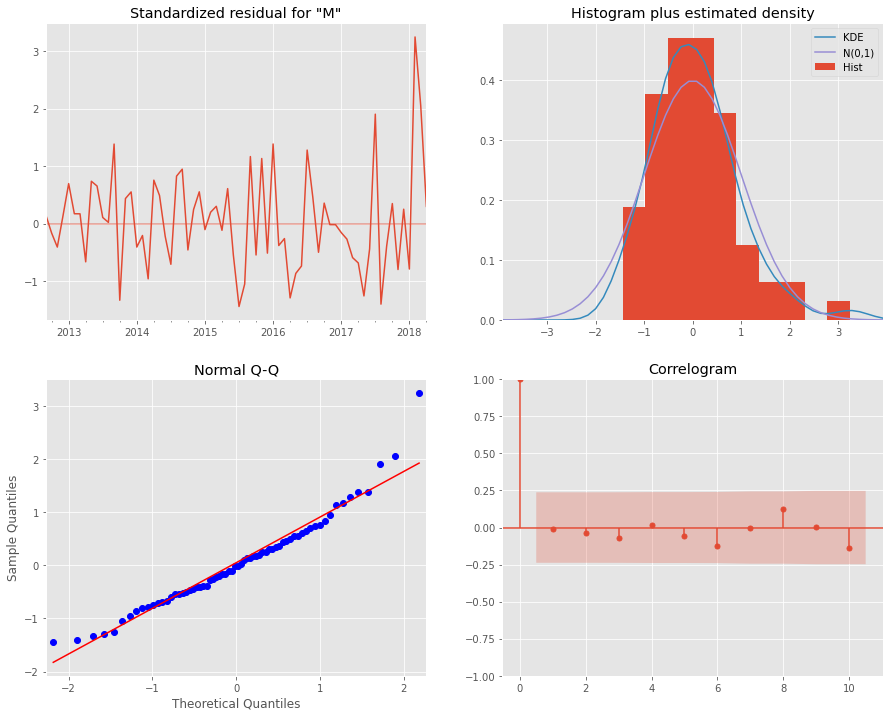

In [136]:
#shows results of model 2
results2.plot_diagnostics(figsize=(15, 12))
plt.show()

AIC is smaller and correlogram has smaller residuals.

### Forecasting

#### Non-dynamic

The model sequentially predicts one-step-ahead using the true value from previous time step instead of using predicted value.

In [147]:
# Get predictions starting from 2015 
pred = output2.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_conf = pred.conf_int()

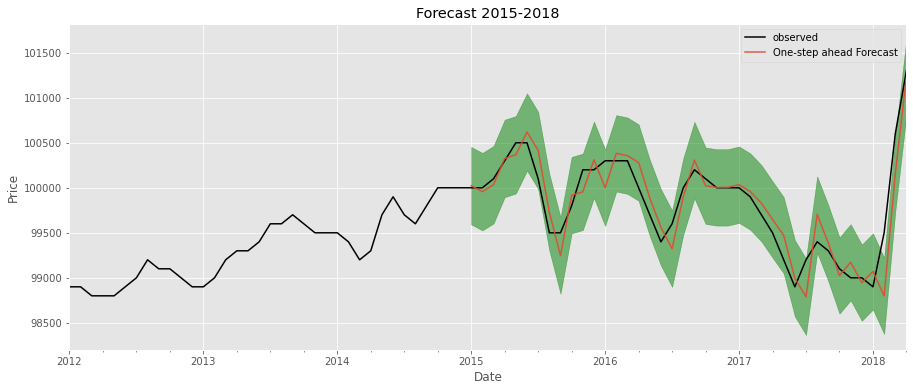

In [148]:
# Plot real vs predicted values along with confidence interval

rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = zip10['2012':].plot(label='observed', color= 'black')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Forecast 2015-2018')
plt.legend()

plt.show()

Forecasts align with true values as seen above with overall increase in trend.  Now we will check for accuracy use RMSE (root mean squared error).

In [149]:
# Get the real and predicted values
zip10_forecasted = pred.predicted_mean
zip10_truth = zip10['2015-01':]

# Compute the mean square error
mse = ((zip10_forecasted - zip10_truth) ** 2).mean()**.5
print('The Root Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Root Mean Squared Error of our forecasts is 214.26


Our model predicted on average within 214.26 dollars the price of homes from 2015-2018

#### Dynamic forecasting

The model continuously predicts one-step ahead (t+1) and then for the 2nd step ahead (t+2) prediction, it appends predicted value (t+1) to data, re-fits model on new expanded data then makes 2nd step ahead forecast.

In [150]:
# Get dynamic predictions with confidence intervals as above 
pred_dynamic = output2.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

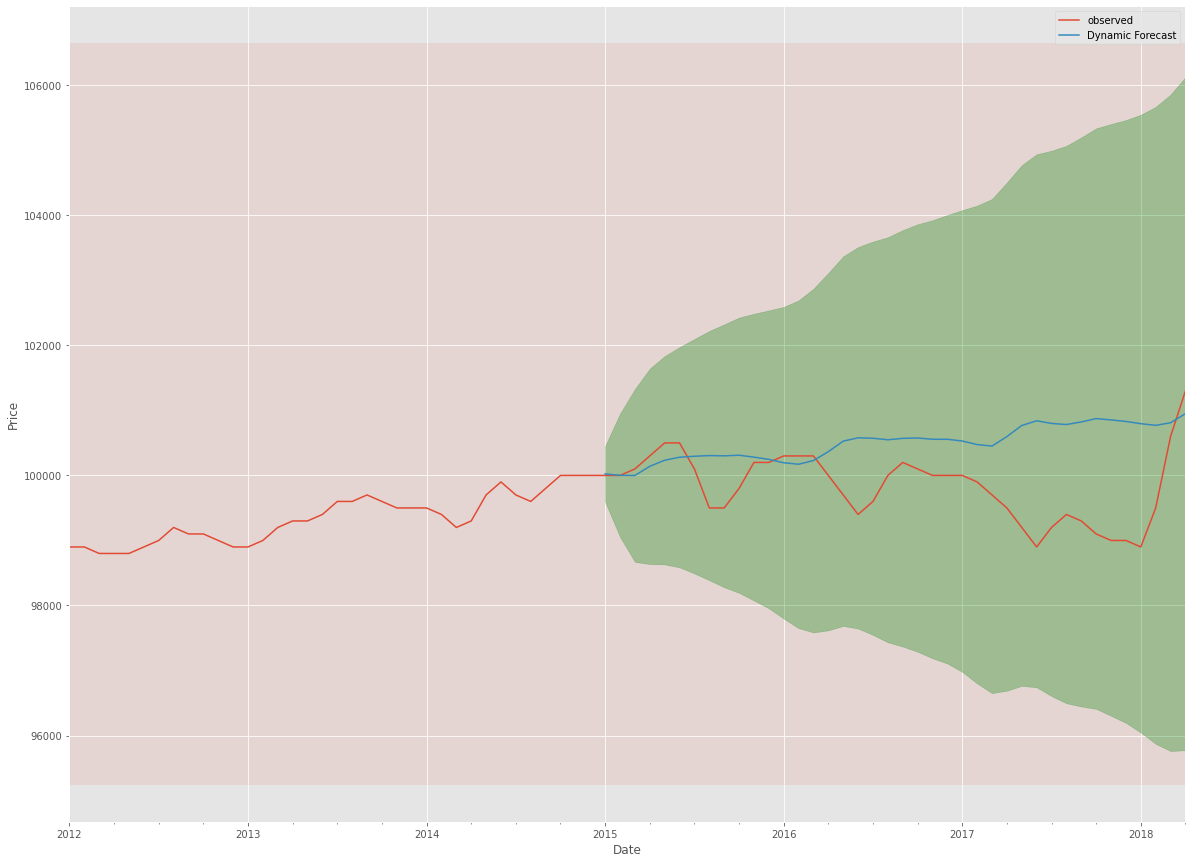

In [152]:
# Plot the dynamic forecast with confidence intervals.

ax = zip10['2012':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), zip10_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()

In [155]:
# Extract the predicted and true values of our time series
zip10_forecasted1 = pred_dynamic.predicted_mean
zip10_truth1 = zip10['2015-01-01':]

# Compute the mean square error
mse = ((zip10_forecasted1 - zip10_truth1) ** 2).mean()**.5
print('The Root Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Root Mean Squared Error of our forecasts is 960.87


Dynamic Model is not as accurate as nondynamic because next step guess are based on previous guess as opposed to true value.

#### Future Prediction

The .get_forecast() method of our time series output can compute forecasted values for a specified number of steps ahead.

In [156]:
# Get forecast 3 years ahead in future
prediction = output2.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

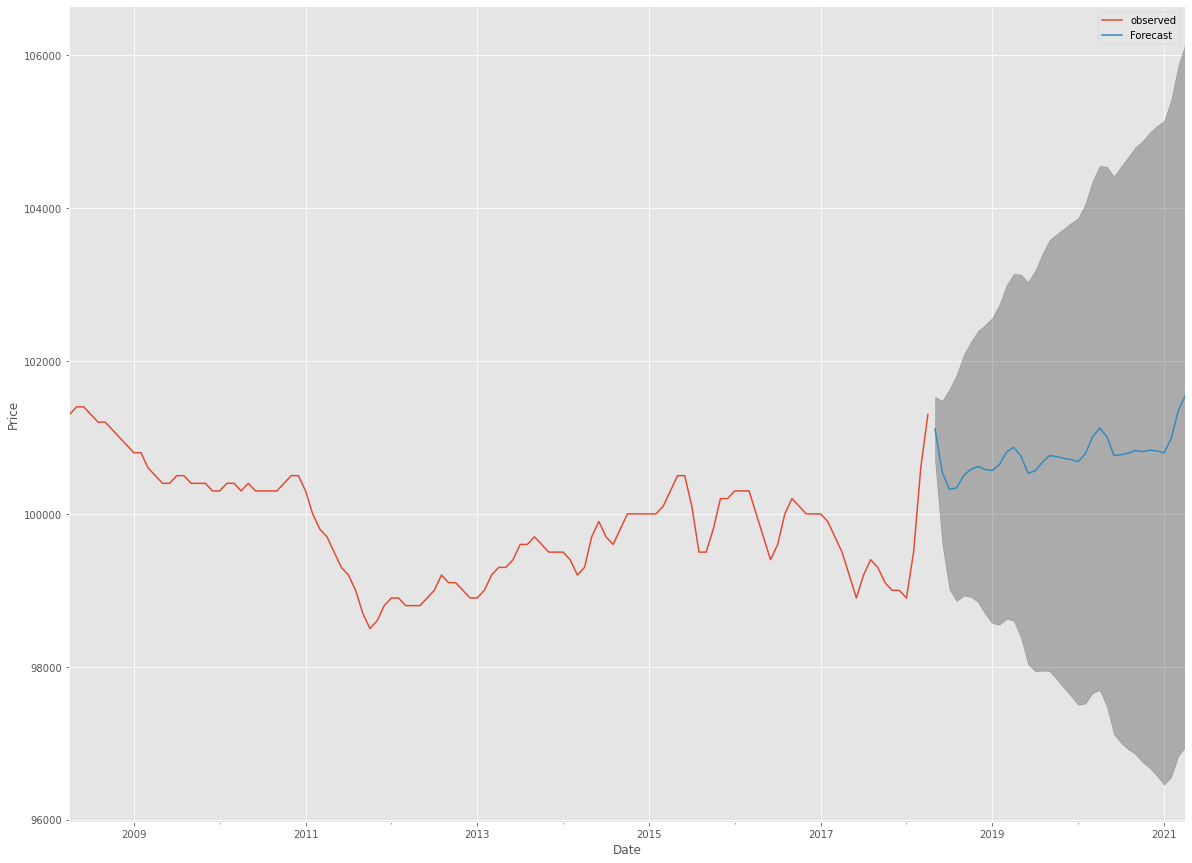

In [157]:
# Plot future predictions 
ax = zip10.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Price')

plt.legend()
plt.show()

Our model shows a price correction followed by steady rise in price in the next three years.

### Findings

10 of the top 50 zipcodes with the highest 10 year ROI were in Santa Clara County.  The average ROI over 10 years was 88% in Santa Clara county as compared to 13% on average over the same period nationwide.

4 of the top 5 counties with the most top 50 '3 year ROI' zipcodes are in Florida.  The average 3 year ROI in Florida is 36% as compared to the 21% national average.

The best investment for a longer time horizon is Santa Clara County in California.  For investors more interested in short term flips, the state of Florida and specifically Brevard, Volusia, Polk, and Duval counties.

Given the relative safety of real estate home investing as compared to other investment instruments, CV should be viewed secondarily to predicted ROI.  Our Forecast model predict a healthy ROI in the next three years.

5 zipcodes with the highest 10 year ROI: 

1. 02116 in Boston, MA
2. 03215 in Waterville Valley, New Hampshire
3. 94574 in St. Helena, CA
4. 96752 in Kauai County, Hawaii
5. 96722 in Kaui County, Hawaii

5 zipcodes with highest 3 year ROI:
1. 2790 in northeastern North Carolina
2. 30032 in Dekalb County, Georgia
3. 19134 in Philadelphia, PA
4. 28208 in Charlotte, North Carolina
5. 33705 in St. Petersberg, Florida

5 zipcodes with lowest 10 year CV:
1. 64836 in Jasper County, Missouri
2. 16508 in Erie, PA
3. 64801 in Jasper County, Missouri
4. 64870 in Jasper Country, Missouri
5. 79934 in El Paso, Texas